In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
##imports
import re, string
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
df_fake = pd.read_csv('data/Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
df_true = pd.read_csv('data/True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
df_true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
df_fake['label'] = [1]*len(df_fake)
df_true['label'] = [0]*len(df_true)
df_fake['num_words'] = df_fake['text'].apply(lambda x: len(x.split()))
df_true['num_words'] = df_true['text'].apply(lambda x: len(x.split()))

In [7]:
df_explore_words = pd.DataFrame(df_fake['num_words'].describe()).rename({'num_words':'fake_words'},axis=1)
df_explore_words['True_words'] = df_true['num_words'].describe()
df_explore_words

,fake_words,True_words
count,23481.000000,21417.000000
mean,423.197905,385.640099
std,408.388890,274.006204
min,0.000000,0.000000
25%,240.000000,148.000000
50%,363.000000,359.000000
75%,506.000000,525.000000
max,8135.000000,5172.000000


In [8]:
df_fake = df_fake[(df_fake['num_words']>=240)&(df_fake['num_words']<=506)]
df_true = df_true[(df_true['num_words']>=148)&(df_true['num_words']<=525)]
len(df_fake),len(df_true)

(11772, 10731)

In [9]:
df_total = pd.concat([df_fake,df_true],axis=0)
df_total.head()

,title,text,subject,date,label,num_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,305
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,420
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,312


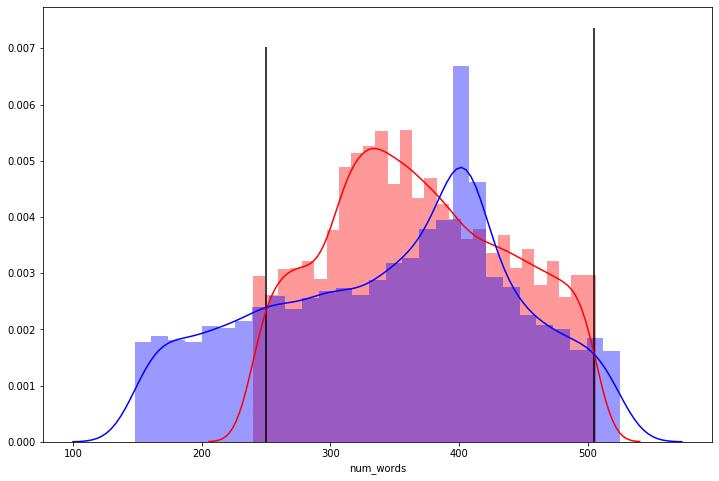

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
# plt.figure()
sns.distplot(df_total[df_total['label']==1]['num_words'],color='red')
sns.distplot(df_total[df_total['label']==0]['num_words'],color='blue')
ax.vlines(250,*ax.get_ylim())
ax.vlines(505,*ax.get_ylim())

In [11]:
df_total[(df_total['num_words']>=250)&(df_total['num_words']<=505)]['label'].value_counts()

1    11408
0     8214
Name: label, dtype: int64

In [12]:
df_total.head()

,title,text,subject,date,label,num_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,305
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,420
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,312


In [25]:
df_final = df_total[['text','label']]
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Christmas day, Donald Trump announced that ...",1
3,Pope Francis used his annual Christmas Day mes...,1
4,The number of cases of cops brutalizing and ki...,1


In [15]:
def clean_lemma_text_blob(x):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    ## Removing Stop Words, Lemmatizing using Text Blob
    #     x = x.lower() ## Lower Case Conversion
    x = x.strip()
    x = regex.sub('', x) ## Removing Punctuations
    word_tokens = x.split()
    filtered_sentence = [Word(i.lower()).lemmatize("v") for i in word_tokens if not i in stop_words] 
    filtered_sentence = ' '.join(filtered_sentence)
    if(len(filtered_sentence.split())>0):
        p_blob = TextBlob(filtered_sentence)
        m = np.array(p_blob.tags)
#         m = m[(m[:,1]=='NN') | (m[:,1] =='JJ') | (m[:,1] =='VBP') | (m[:,1] =='VB') ]
        m = m[~(m[:,1]=='NN')]
        filtered_sentence = ' '.join(m[:,0])
        filtered_sentence = filtered_sentence.lower()
        return filtered_sentence
    else:
        return ''
    

In [16]:
def clean_text_df(df):
    df['text_noun_cleaned']=df['text'].apply(lambda x: clean_lemma_text_blob(x))
    return df

In [17]:
def get_sentiment_features(df):
    df['polarity']=df['text'].apply(lambda x:TextBlob(x).sentiment.polarity)
    df['subjectivity']=df['text'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
    return df

In [18]:
def data_transformation(df,tfidf_params = 50):
    ## Tweaking parameters
    vectorizer = TfidfVectorizer(min_df=tfidf_params,ngram_range=(1,2))
    X = vectorizer.fit_transform(df['text_noun_cleaned'])
    df_input = pd.DataFrame(X.toarray())
    df_input.columns = vectorizer.get_feature_names()
    if 'label' in df.columns:
        df_input['label'] = df['label']
    df_input['polarity'] = df['polarity']
    df_input['subjectivity'] = df['subjectivity']
    return df_input, vectorizer

In [32]:
def model_selection(df_input):
    results = {}
    l = list(df_input.columns)
    l.remove('label')
    X_train, X_test, y_train, y_test = train_test_split(df_input[l], df_input['label'],
                                                    test_size=0.33, random_state=42)
    
    ## BNB
    clf_bnb = BernoulliNB().fit(X_train, y_train)
    ypred=clf_bnb.predict(X_test)
    acc_BNB = accuracy_score(y_test,ypred)
    print("Accuracy for BNB model with/without tuning: ", acc_BNB)
    results[clf_bnb] = acc_BNB
    
    ## Random Forest
    clf_rf = RandomForestClassifier(random_state=42)
    param_grid = [{ 
        'n_estimators': np.arange(10,110,10),
        'max_depth' : [4,5,6,7,8]
    }]
    CV_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv= 5)
    CV_rf.fit(X_train, y_train)
    y_pred = CV_rf.predict(X_test)
    acc_RF = accuracy_score(y_test,y_pred)
    print("Accuracy for Random Forest after CV: ", acc_RF)
    results[CV_rf] = acc_RF
    
    ## KNN
    clf_knn = KNeighborsClassifier()
    param_grid = [{ 
        'n_neighbors': np.arange(8,20)
    }]
    CV_knn= GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv= 5)
    CV_knn.fit(X_train, y_train)
    y_pred = CV_knn.predict(X_test)
    acc_KNN = accuracy_score(y_test,y_pred)
    print("Accuracy for KNN after CV data: ",acc_KNN)
    results[CV_knn] = acc_KNN
    
    ## Voting Classifier
    eclf1 = VotingClassifier(estimators=[('nb', clf_bnb), ('rf', CV_rf), ('knn', CV_knn)], voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    ypred = eclf1.predict(X_test)
    acc_VC = accuracy_score(y_test,ypred)
    print("Accuracy for voting classifier: ",acc_VC)
    results[eclf1] = acc_VC
    
    best_estimator = max(results, key=lambda k: results[k])
    return results,best_estimator
    

In [20]:
def train_pipeline(df):
    ## Steps
    # 1.Reading files
#     df = read_files(filename)
    # 2. Checking for imbalance in data
#     df = rebalance_data(df)
    # 3. Text Cleaning 
    df = clean_text_df(df)
    # 4. Sentiment based features
    df = get_sentiment_features(df)
    # 5. Data Transformation
    df_input,vect = data_transformation(df)
    # 6. Model Selection 
    trained_classifier = model_selection(df_input)
    return trained_classifier, vect

In [26]:
classifier,vect = train_pipeline(df_final)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy for BNB model with/without tuning:  0.971182332345812



KeyboardInterrupt



In [27]:
df_final.head()

,text,label,text_noun_cleaned,polarity,subjectivity
0,Donald Trump just couldn t wish all Americans ...,1,wish americans happy new leave instead give en...,0.082132,0.599895
1,House Intelligence Committee Chairman Devin Nu...,1,nunes go bad he like many us christopher steel...,-0.005004,0.334098
2,"On Christmas day, Donald Trump announced that ...",1,on christmas donald trump would back follow fo...,-0.023118,0.394086
3,Pope Francis used his annual Christmas Day mes...,1,use annual donald without even name the delive...,-0.011722,0.495222
4,The number of cases of cops brutalizing and ki...,1,the cop people color seem see now another far ...,0.004710,0.502536


In [28]:
df_input,vect = data_transformation(df_final)

In [30]:
len(vect.get_feature_names())

6908

In [33]:
results,trained_classifier = model_selection(df_input)

Accuracy for BNB model with/without tuning:  0.971182332345812


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-d1a4974d510b>", line 1, in <module>
    results,trained_classifier = model_selection(df_input)
  File "<ipython-input-32-0b5d33de7f49>", line 22, in model_selection
    CV_rf.fit(X_train, y_train)
  File "C:\Users\PNanduri\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py", line 712, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\PNanduri\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py", line 1153, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\PNanduri\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py", line 691, in evaluate_candidates
    cv.split(X, y, groups)))
  File 

KeyboardInterrupt: 